# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp

import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import roc_auc_score

#from imblearn.over_sampling import SMOTE
import lightgbm
from lightgbm import LGBMClassifier
#import catboost
#from catboost import CatBoostClassifier

# Data Size Shrinkage Helper Function

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Read Data

In [ ]:
invoice_test = pd.read_csv('./data/invoice_test.csv',low_memory=False)
print(f'invoice_test has {invoice_test.shape[0]:,} rows and {invoice_test.shape[1]} cols','\n')

invoice_train = pd.read_csv('./data/invoice_train.csv',low_memory=False)
print(f'invoice_train has {invoice_train.shape[0]:,} rows and {invoice_train.shape[1]} cols','\n')


invoice_test has 1,939,730 rows and 16 cols 

invoice_train has 4,476,749 rows and 16 cols 



In [ ]:
client_test = pd.read_csv('./data/client_test.csv',low_memory=False)
print(f'client_test has {client_test.shape[0]:,} rows and {client_test.shape[1]} cols','\n')

client_train = pd.read_csv('./data/client_train.csv',low_memory=False)
print(f'client_train has {client_train.shape[0]:,} rows and {client_train.shape[1]} cols','\n')

client_test has 58,069 rows and 5 cols 

client_train has 135,493 rows and 6 cols 



In [ ]:
sub=pd.read_csv('./SampleSubmission.csv')

## EDA

posx and posy should be finite values
posx and posy should be finite values


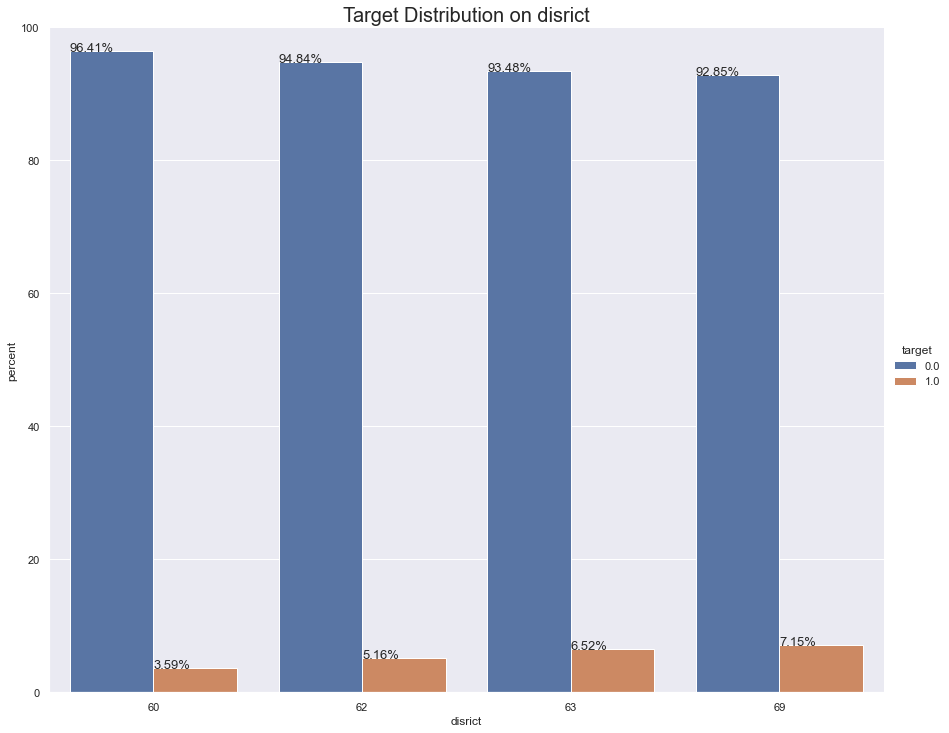

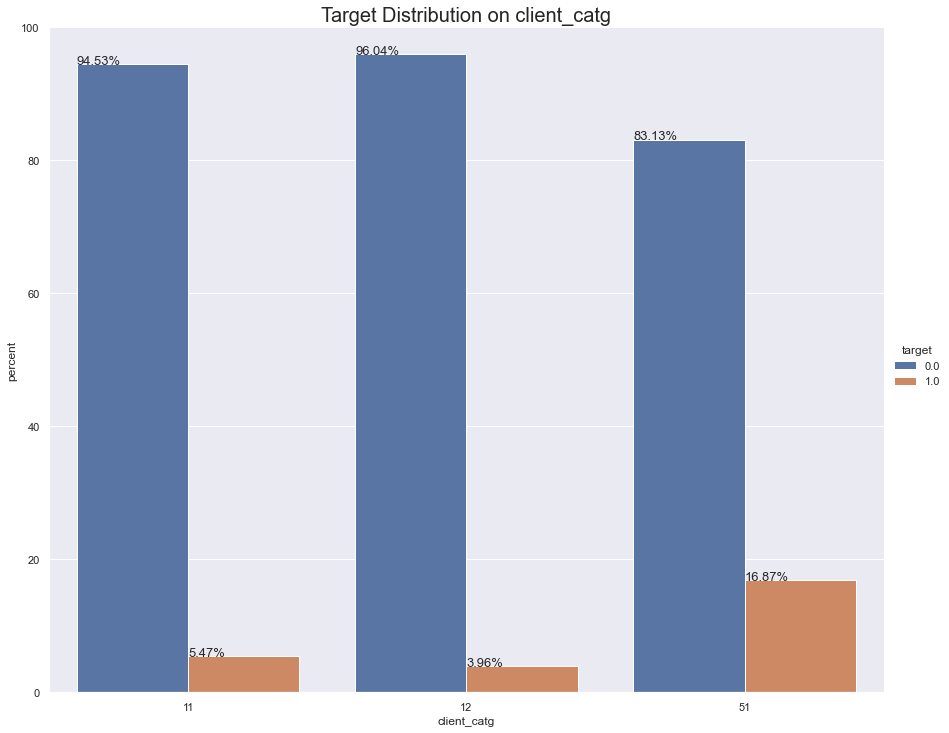

posx and posy should be finite values
posx and posy should be finite values


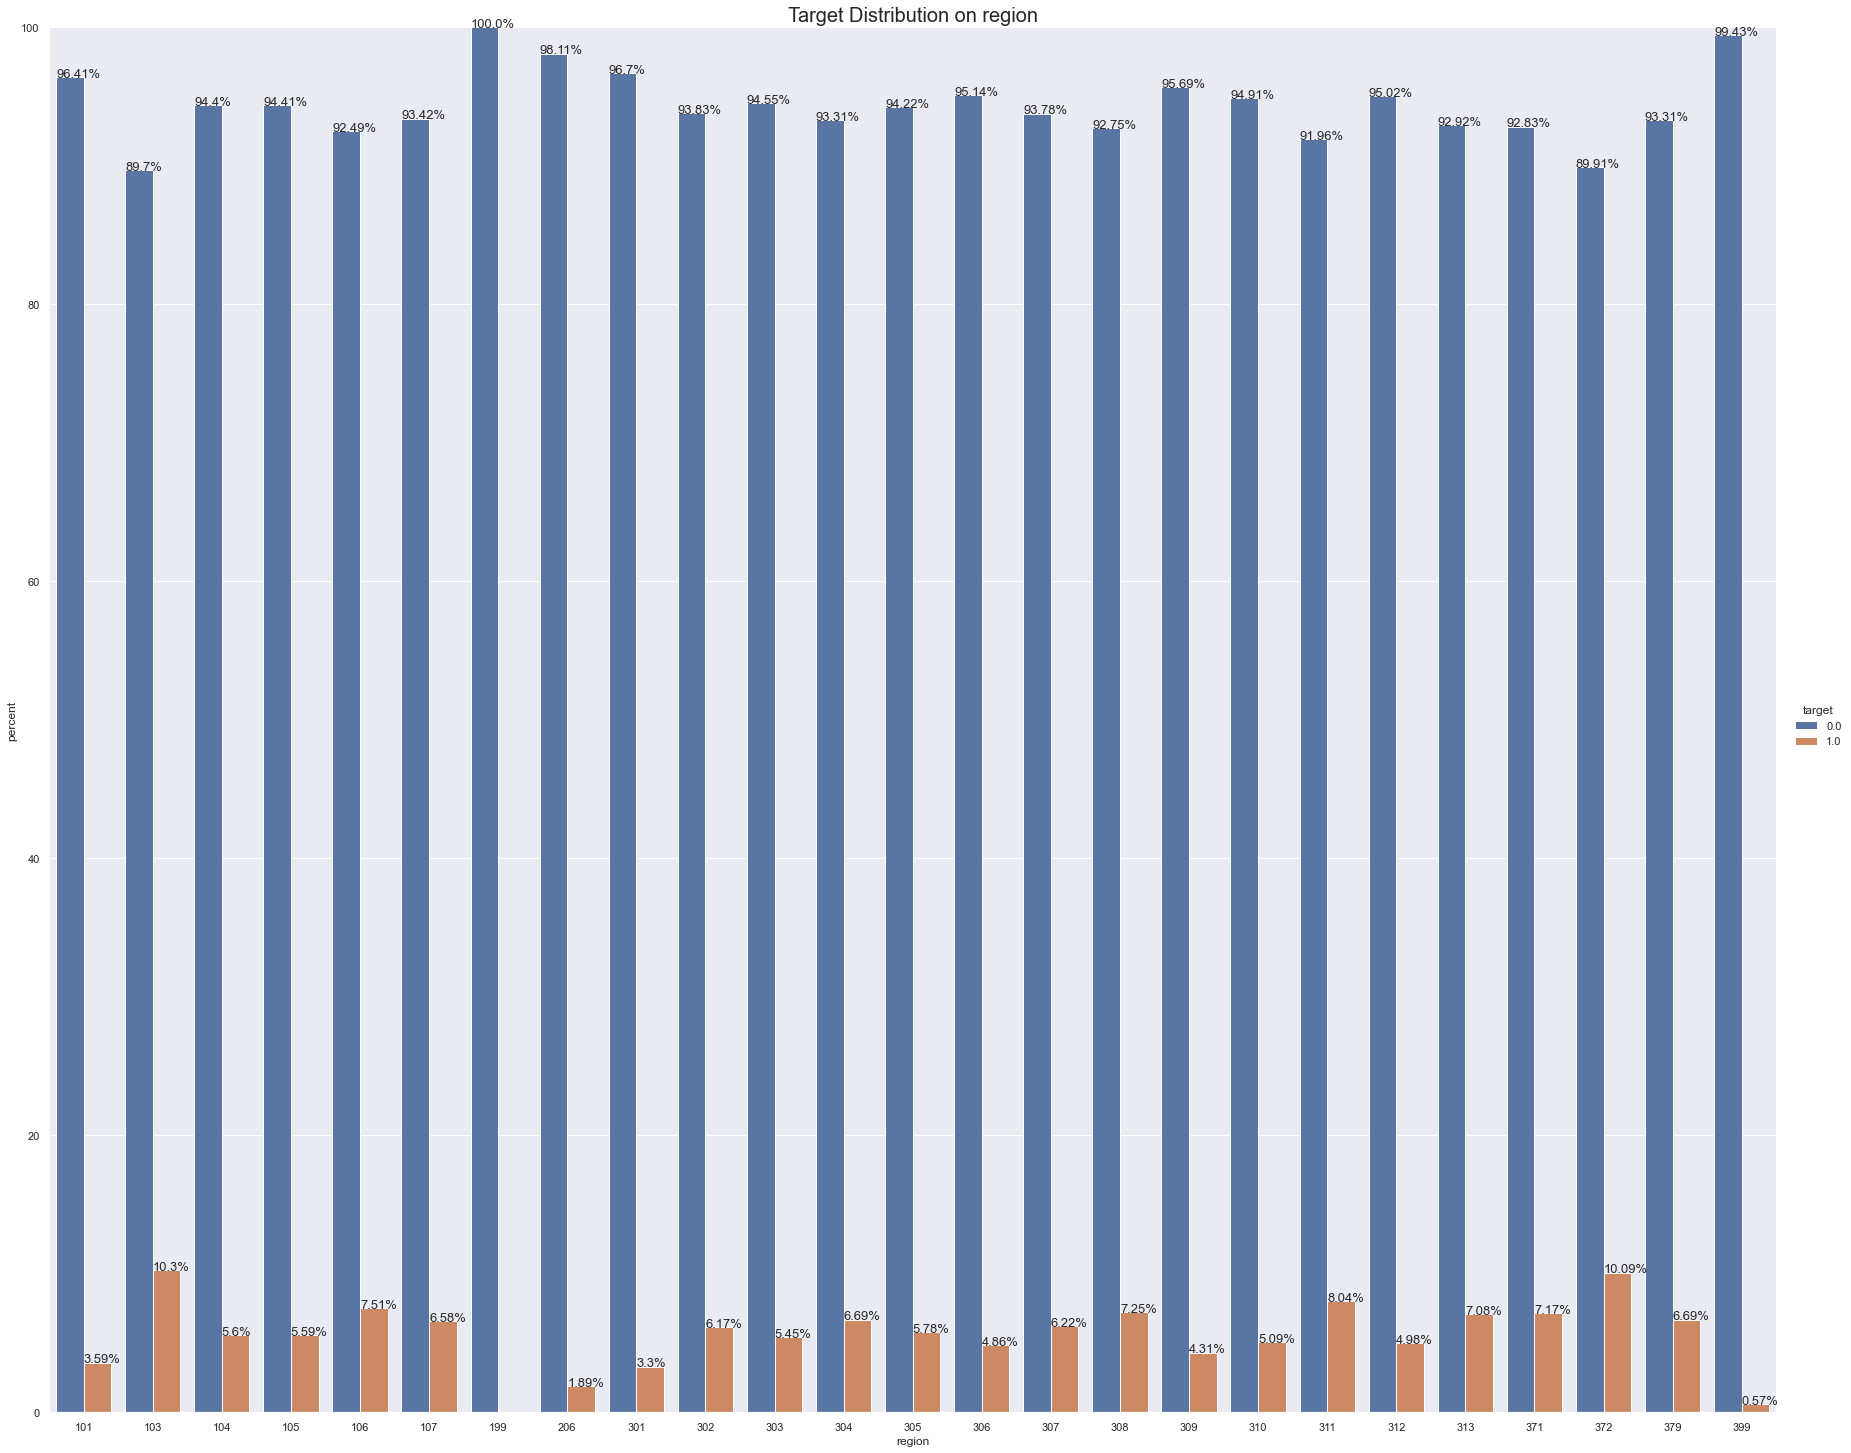

In [ ]:
all_x = ['disrict','client_catg','region']
y = 'target'

for x in all_x:
    df1 = client_train.groupby(x)[y].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()

    if x == 'region':
        height = 20
    else:
        height = 10
    g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1,height = height, aspect = 1.25)
    g.ax.set_title(f'Target Distribution on {x}',fontsize=20)
    g.ax.set_ylim(0,100)

    for p in g.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt, size=13)

    figure = g.fig
    figure.savefig(f'./chart/Target Distribution on {x}.jpg',format='jpeg',
                   dpi=100,
                   bbox_inches='tight')

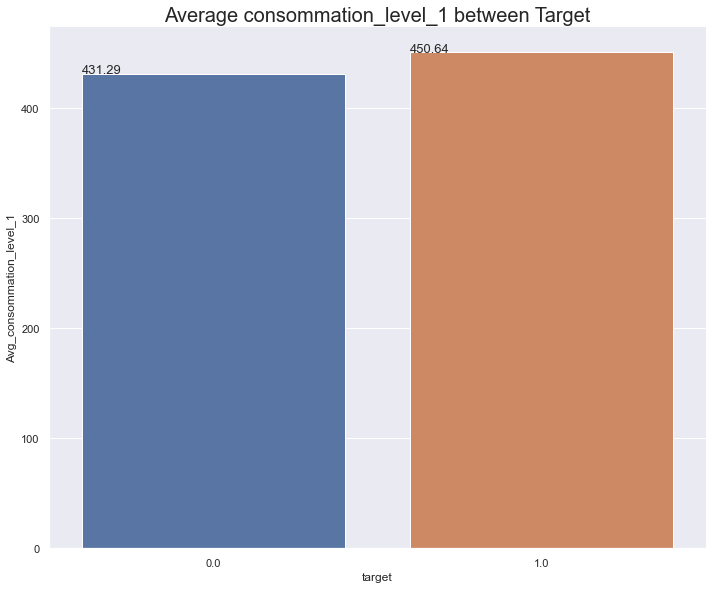

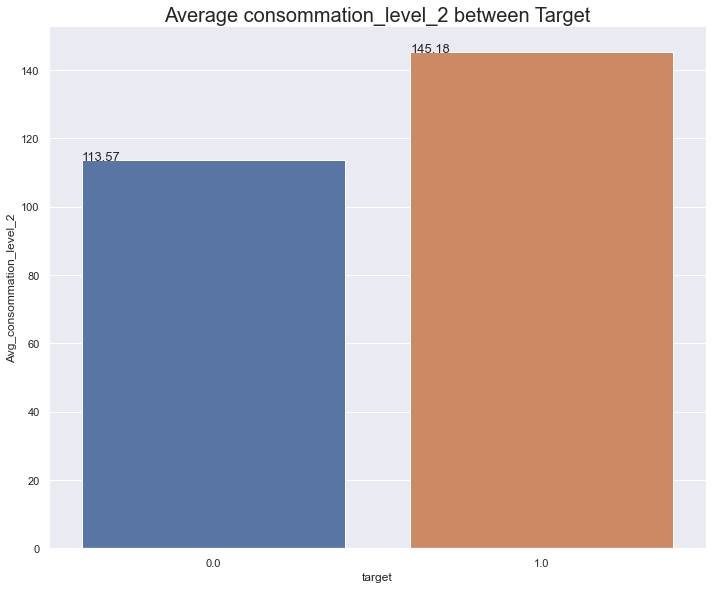

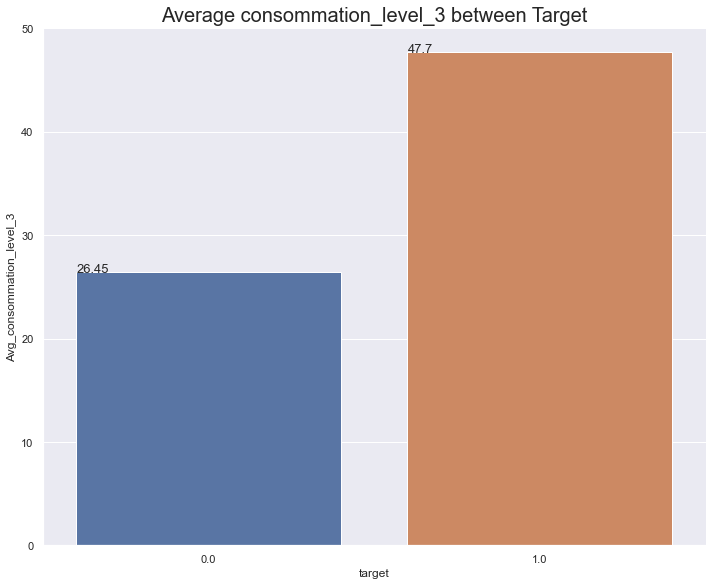

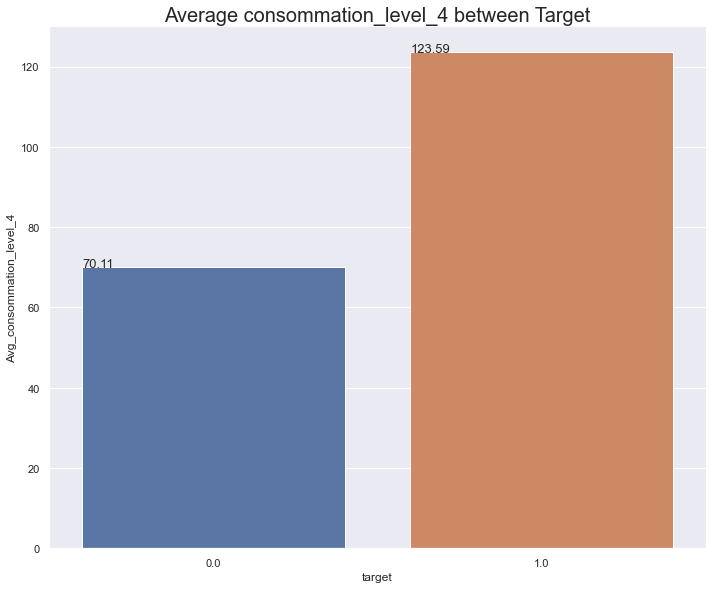

In [ ]:
df_merge = client_train.merge(invoice_train.groupby(['client_id']).agg({'consommation_level_1':np.mean,
                                          'consommation_level_2':np.mean,
                                          'consommation_level_3':np.mean,
                                          'consommation_level_4':np.mean}).reset_index(),
                         how='inner',on='client_id')
consommations = ['consommation_level_1','consommation_level_2','consommation_level_3','consommation_level_4']

for consommation in consommations:
    df1 = df_merge.groupby(['target'])[consommation].mean().rename(f'Avg_{consommation}').reset_index()

    g = sns.catplot(x='target',y=f'Avg_{consommation}',kind='bar',data=df1,height = 8, aspect = 1.25)
    g.ax.set_title(f'Average {consommation} between Target',fontsize=20)

    for p in g.ax.patches:
        txt = str(p.get_height().round(2))
        txt_x = p.get_x()
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt, size=13)

    figure = g.fig
    figure.savefig(f'./chart/Average {consommation} between Target.jpg',format='jpeg',
                   dpi=100,
                   bbox_inches='tight')


## Data Cleansing

### Bad counter_statue and remarque

In [ ]:
cate_cols = ['counter_statue','reading_remarque']

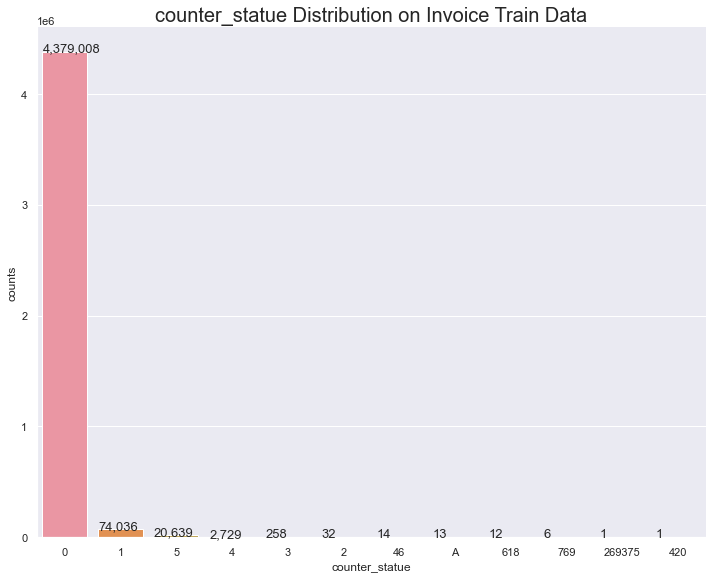

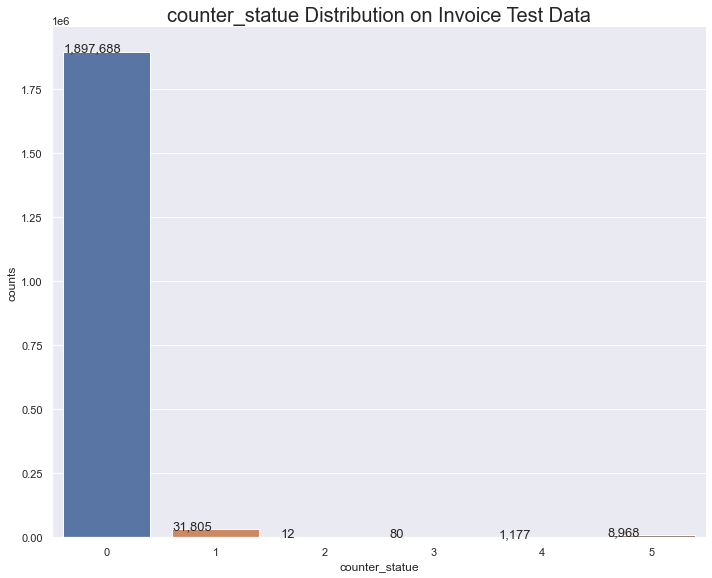

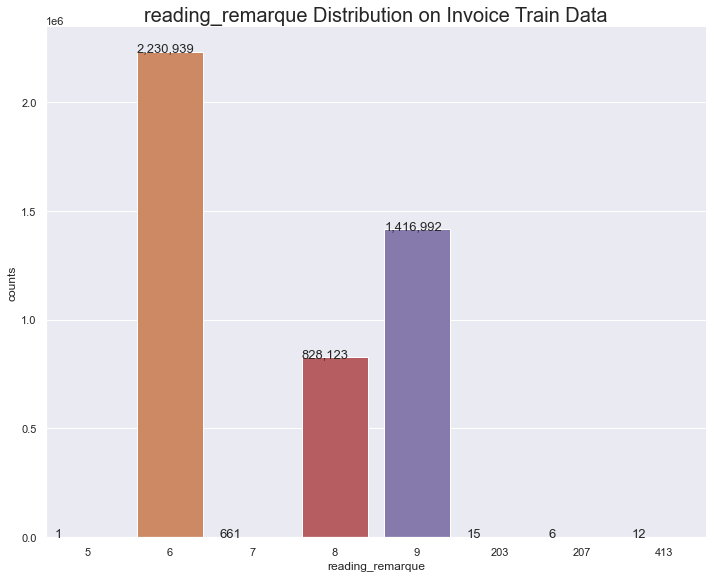

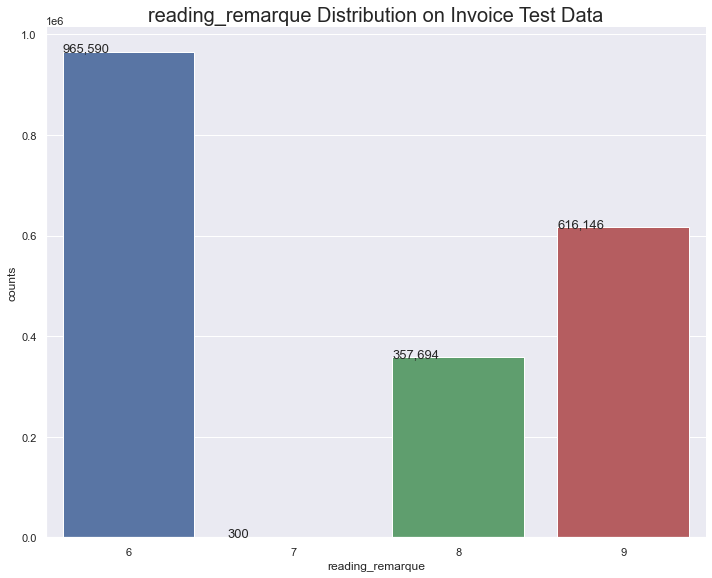

In [ ]:
for cate_col in cate_cols:
    df1 = invoice_train[cate_col].value_counts().rename_axis(cate_col).to_frame('counts').reset_index()
    df2 = invoice_test[cate_col].value_counts().rename_axis(cate_col).to_frame('counts').reset_index()

    g1 = sns.catplot(x=cate_col,y='counts',kind='bar',data=df1,height = 8, aspect = 1.25)
    g1.ax.set_title(f'{cate_col} Distribution on Invoice Train Data',fontsize=20)
    for p in g1.ax.patches:
        txt = f'{p.get_height() :,.0f}'
        txt_x = p.get_x()
        txt_y = p.get_height()
        g1.ax.text(txt_x,txt_y,txt, size=13)

    figure1 = g1.fig
    figure1.savefig(f'./chart/{cate_col} Distribution on Invoice Train Data.jpg',format='jpeg',
                   dpi=100,
                   bbox_inches='tight')


    g2 = sns.catplot(x=cate_col,y='counts',kind='bar',data=df2,height = 8, aspect = 1.25)
    g2.ax.set_title(f'{cate_col} Distribution on Invoice Test Data',fontsize=20)
    for p in g2.ax.patches:
        txt = f'{p.get_height() :,.0f}'
        txt_x = p.get_x()
        txt_y = p.get_height()
        g2.ax.text(txt_x,txt_y,txt, size=13)

    figure2 = g2.fig
    figure2.savefig(f'./chart/{cate_col} Distribution on Invoice Test Data.jpg',format='jpeg',
                   dpi=100,
                   bbox_inches='tight')

### Wrong Month Number

In [ ]:
invoice_train_month = invoice_train['months_number'].value_counts().rename_axis('month_number').to_frame('counts').reset_index()
invoice_test_month = invoice_test['months_number'].value_counts().rename_axis('month_number').to_frame('counts').reset_index()


In [ ]:
invoice_train_month.tail()

,month_number,counts
1365,430834,1
1366,179002,1
1367,186166,1
1368,81499,1
1369,463554,1


In [ ]:
invoice_test_month.tail()

,month_number,counts
909,11467,1
910,16031,1
911,6198,1
912,2169,1
913,26699,1


In [ ]:
#invoice_train[invoice_train['months_number']>100]['client_id'].value_counts()

In [ ]:
month_error_sample = invoice_train[invoice_train['client_id']=='train_Client_100551'].sort_values(by=['counter_type','invoice_date'])

In [ ]:
month_error_sample[['client_id', 'invoice_date', 'counter_number','old_index',
       'new_index', 'months_number', 'counter_type']]

,client_id,invoice_date,counter_number,old_index,new_index,months_number,counter_type
20214,train_Client_100551,2009-03-09,1099471,0,495,3311,ELEC
20219,train_Client_100551,2009-11-05,1099471,0,342,495,ELEC
20212,train_Client_100551,2010-06-05,1099471,0,9971,17815,ELEC
20213,train_Client_100551,2010-08-01,1099471,0,3311,9971,ELEC
20211,train_Client_100551,2010-08-30,1099471,0,17815,25778,ELEC
20215,train_Client_100551,2011-03-14,1099471,0,25778,25778,ELEC
20220,train_Client_100551,2011-08-09,545768,0,6828,8,ELEC
20217,train_Client_100551,2012-09-01,545768,6828,17146,4,ELEC
20218,train_Client_100551,2014-06-05,545768,20841,20841,6,ELEC
20216,train_Client_100551,2017-04-27,545768,20842,20842,30,ELEC


In [ ]:
idx = month_error_sample['months_number']>100
month_error_sample.loc[idx,['old_index','new_index']] = month_error_sample.loc[idx,['new_index','months_number']].values
month_error_sample.loc[idx,['months_number']] = 4
month_error_sample.loc[month_error_sample['months_number']==0,['months_number']] = 4

In [ ]:
month_error_sample[['client_id', 'invoice_date', 'counter_number','old_index',
       'new_index', 'months_number', 'counter_type']]

,client_id,invoice_date,counter_number,old_index,new_index,months_number,counter_type
20214,train_Client_100551,2009-03-09,1099471,495,3311,4,ELEC
20219,train_Client_100551,2009-11-05,1099471,342,495,4,ELEC
20212,train_Client_100551,2010-06-05,1099471,9971,17815,4,ELEC
20213,train_Client_100551,2010-08-01,1099471,3311,9971,4,ELEC
20211,train_Client_100551,2010-08-30,1099471,17815,25778,4,ELEC
20215,train_Client_100551,2011-03-14,1099471,25778,25778,4,ELEC
20220,train_Client_100551,2011-08-09,545768,0,6828,8,ELEC
20217,train_Client_100551,2012-09-01,545768,6828,17146,4,ELEC
20218,train_Client_100551,2014-06-05,545768,20841,20841,6,ELEC
20216,train_Client_100551,2017-04-27,545768,20842,20842,30,ELEC


### Remove clients with bad counter_statue and remarque in train set

In [ ]:
#Remove clients with bad counter_statue and remarque in train set
bad_statue_client = ['train_Client_78338','train_Client_13203','train_Client_53725','train_Client_47780','train_Client_30467']
invoice_train = invoice_train[~invoice_train['client_id'].isin(bad_statue_client)]
invoice_train = invoice_train[~((invoice_train['client_id']=='train_Client_79075') & (invoice_train['counter_type']=='GAZ'))].reset_index(drop=True)

client_train = client_train[~client_train['client_id'].isin(bad_statue_client)].reset_index(drop=True)

# Prepare Client Data

In [ ]:
client_test.head()

,disrict,client_id,client_catg,region,creation_date
0,62,test_Client_0,11,307,28/05/2002
1,69,test_Client_1,11,103,06/08/2009
2,62,test_Client_10,11,310,07/04/2004
3,60,test_Client_100,11,101,08/10/1992
4,62,test_Client_1000,11,301,21/07/1977


In [ ]:
def prepare_client(df,Train=True):

    df['creation_date'] = pd.to_datetime(df['creation_date'],dayfirst=True)
    df['creation_day'] = df['creation_date'].dt.day
    df['creation_month'] = df['creation_date'].dt.month
    df['creation_year'] = df['creation_date'].dt.year
    df['duration']=(2022 - df['creation_date'].dt.year)*12 - df['creation_date'].dt.month

    df['disrict'] = df['disrict'].astype(str).astype('category')
    df['client_catg'] = df['client_catg'].astype(str).astype('category')
    df['region_group'] =  df['region'].apply(lambda x: 1 if x<=100 else 3 if x>=300 else 2)
    df['region'] = df['region'].astype(str).astype('category')

    if Train:

        col_seq = ['client_id','disrict','client_catg', 'region','region_group','creation_date',
                   'creation_day','creation_month','creation_year','duration','target']
    else:
        col_seq = ['client_id','disrict','client_catg', 'region','region_group','creation_date',
                   'creation_day','creation_month','creation_year','duration']
    df = df[col_seq]

    return df

In [ ]:
client_train = reduce_mem_usage(prepare_client(client_train,Train=True))
print(client_train.shape)

Mem. usage decreased to  3.62 Mb (58.2% reduction)
(135488, 11)


In [ ]:
client_train.head()

,client_id,disrict,client_catg,region,region_group,creation_date,creation_day,creation_month,creation_year,duration,target
0,train_Client_0,60,11,101,2,1994-12-31,31,12,1994,324,0.0
1,train_Client_1,69,11,107,2,2002-05-29,29,5,2002,235,0.0
2,train_Client_10,62,11,301,3,1986-03-13,13,3,1986,429,0.0
3,train_Client_100,69,11,105,2,1996-07-11,11,7,1996,305,0.0
4,train_Client_1000,62,11,303,3,2014-10-14,14,10,2014,86,0.0


In [ ]:
client_test = reduce_mem_usage(prepare_client(client_test,Train=False))
print(client_test.shape)

Mem. usage decreased to  1.44 Mb (55.9% reduction)
(58069, 10)


# Prepare Invoice Data

## Concat Invoice Train and Test

In [ ]:
data = pd.concat([invoice_train,invoice_test],axis=0).reset_index(drop=True)
data = reduce_mem_usage(data)
print(data.shape)

Mem. usage decreased to 446.69 Mb (43.0% reduction)
(6416334, 16)


In [ ]:
# Adjust Wrong Column Vlues
idx = data['months_number']>100
data.loc[idx,['old_index','new_index']] = data.loc[idx,['new_index','months_number']].values
data.loc[idx,['months_number']] = 4
data.loc[data['months_number']==0,['months_number']] = 4

# Adjust Consumption
data['consommation_level_1'] = round(data['consommation_level_1']/data['months_number'],0)
data['consommation_level_2'] = round(data['consommation_level_2']/data['months_number'],0)
data['consommation_level_3'] = round(data['consommation_level_3']/data['months_number'],0)
data['consommation_level_4'] = round(data['consommation_level_4']/data['months_number'],0)

In [ ]:
# Adjust Column Type
data['invoice_date'] = pd.to_datetime(data['invoice_date'])

#data['tarif_type'] = data['tarif_type'].astype(str)
data['tarif_type_str'] = data['tarif_type'].astype(str)

#data['counter_number'] = data['counter_number'].astype(str)

data['counter_statue'] = data['counter_statue'].astype(str)
data['counter_statue_str'] = data['counter_statue']

#data['counter_code'] = data['counter_code'].astype(str)
data['counter_code_str'] = data['counter_code'].astype(str)

#data['reading_remarque'] = data['reading_remarque'].astype(str)
data['reading_remarque_str'] = data['reading_remarque'].astype(str)

In [ ]:
# Helper Column for Counter Type Split
data['GAZ']='GAZ'
data['ELEC']='ELEC'

## Feature Engineering

### Add Time Features

In [ ]:
data['invoice_date_day'] = data['invoice_date'].dt.day
data['invoice_date_month'] = data['invoice_date'].dt.month
data['invoice_date_year'] = data['invoice_date'].dt.year

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train[['Salary']])

X_train['Salary_MinMax'] = scaler.transform(X_train[['Salary']])
X_test['Salary_MinMax'] = scaler.transform(X_test[['Salary']])


### Add Diff Features

In [ ]:
data['index_diff'] = data['new_index']-data['old_index']

In [ ]:
data['invoice_diff']=data.sort_values(by=['client_id','counter_type','invoice_date']).groupby(['client_id','counter_type'])['invoice_date'].diff().dt.days
data['con_1_diff']=data.sort_values(by=['client_id','counter_type','counter_number','old_index']).groupby(['client_id','counter_type','counter_number'])['consommation_level_1'].diff()
data['con_2_diff']=data.sort_values(by=['client_id','counter_type','counter_number','old_index']).groupby(['client_id','counter_type','counter_number'])['consommation_level_2'].diff()
data['con_3_diff']=data.sort_values(by=['client_id','counter_type','counter_number','old_index']).groupby(['client_id','counter_type','counter_number'])['consommation_level_3'].diff()
data['con_4_diff']=data.sort_values(by=['client_id','counter_type','counter_number','old_index']).groupby(['client_id','counter_type','counter_number'])['consommation_level_4'].diff()
data['index_diff_diff']=data.sort_values(by=['client_id','counter_type','counter_number','old_index']).groupby(['client_id','counter_type','counter_number'])['index_diff'].diff()


### Interaction Columns

In [ ]:
data['number_plus_code'] = data['counter_number'] + data['counter_code']
data['number_minus_code'] = data['counter_number'] - data['counter_code']
data['number_multi_code'] = data['counter_number'] * data['counter_code']
data['number_div_code'] = data['counter_number'] / data['counter_code']

### Feature Aggregation

In [ ]:
# Create base dataframe for aggregation
base = data[['client_id','ELEC','GAZ']].drop_duplicates()
# Create helper columns for quick mapping
base['ELEC'] = list(zip(base['client_id'],base['ELEC']))
base['GAZ'] = list(zip(base['client_id'],base['GAZ']))

In [ ]:
base.shape

(193557, 3)

In [ ]:
num_feature = ['consommation_level_1','consommation_level_2','consommation_level_3','consommation_level_4',
               'old_index','new_index','number_plus_code','number_minus_code','number_multi_code','number_div_code']

num_diff_feature = ['invoice_diff','con_1_diff','con_2_diff','con_3_diff','con_4_diff','index_diff_diff']

cate_feature = ['tarif_type', 'counter_number','counter_statue', 'counter_code',
                'reading_remarque','counter_coefficient',
                'invoice_date_day','invoice_date_month','invoice_date_year']

cate_freq_feature = ['tarif_type_str','counter_statue_str', 'counter_code_str','reading_remarque_str']


#### Label Encode Categorical Features

In [ ]:
le = LabelEncoder()
for feature in cate_feature:
    le.fit(data[feature])
    data[feature] = le.transform(data[feature])

#### Numerical Feature aggregation

In [ ]:
#num_feature = ['consommation_level_1']

In [ ]:
for feature in (num_feature):
    mean_dict = dict(data.groupby(['client_id','counter_type'])[feature].mean())
    min_dict = dict(data.groupby(['client_id','counter_type'])[feature].min())
    max_dict = dict(data.groupby(['client_id','counter_type'])[feature].max())
    std_dict = dict(data.groupby(['client_id','counter_type'])[feature].std())
    sum_dict = dict(data.groupby(['client_id','counter_type'])[feature].sum())
    for type_ in ['ELEC','GAZ']:
        base[f'{feature}_mean_{type_}'] = base[f'{type_}'].map(mean_dict)
        base[f'{feature}_min_{type_}'] = base[f'{type_}'].map(min_dict)
        base[f'{feature}_max_{type_}'] = base[f'{type_}'].map(max_dict)
        base[f'{feature}_std_{type_}'] = base[f'{type_}'].map(std_dict)
        base[f'{feature}_sum_{type_}'] = base[f'{type_}'].map(sum_dict)

        base[f'{feature}_range_{type_}'] = base[f'{feature}_max_{type_}'] - base[f'{feature}_min_{type_}']
        base[f'{feature}_max_mean_diff_{type_}'] = base[f'{feature}_max_{type_}'] - base[f'{feature}_mean_{type_}']

#### Numerical Diff Feature aggregation

In [ ]:
#num_diff_feature = ['con_1_diff']

In [ ]:
for feature in num_diff_feature:
    mean_dict = dict(data.groupby(['client_id','counter_type'])[feature].mean())
    min_dict = dict(data.groupby(['client_id','counter_type'])[feature].min())
    max_dict = dict(data.groupby(['client_id','counter_type'])[feature].max())
    std_dict = dict(data.groupby(['client_id','counter_type'])[feature].std())
    sum_dict = dict(data.groupby(['client_id','counter_type'])[feature].sum())
    for type_ in ['ELEC','GAZ']:
        base[f'{feature}_mean_{type_}'] = base[f'{type_}'].map(mean_dict)
        base[f'{feature}_min_{type_}'] = base[f'{type_}'].map(min_dict)
        base[f'{feature}_max_{type_}'] = base[f'{type_}'].map(max_dict)
        base[f'{feature}_std_{type_}'] = base[f'{type_}'].map(std_dict)
        base[f'{feature}_sum_{type_}'] = base[f'{type_}'].map(sum_dict)

        base[f'{feature}_range_{type_}'] = base[f'{feature}_max_{type_}'] - base[f'{feature}_min_{type_}']
        base[f'{feature}_max_mean_diff_{type_}'] = base[f'{feature}_max_{type_}'] - base[f'{feature}_mean_{type_}']

#### Categorical Feature aggregation

In [ ]:
#cate_feature = ['tarif_type']

In [ ]:
for feature in cate_feature:
    nunique_dict = dict(data.groupby(['client_id','counter_type'])[feature].nunique())
    mode_dict = dict(data.groupby(['client_id','counter_type'])[feature].agg(lambda x: pd.Series.mode(x)[0]))
    for type_ in ['ELEC','GAZ']:
        base[f'{feature}_nunique_{type_}'] = base[f'{type_}'].map(nunique_dict)
        base[f'{feature}_mode_{type_}'] = base[f'{type_}'].map(mode_dict)

#### Categorical Feature Frequency Aggregation

In [ ]:
# 1. Tarif_type
tarif_group = data.groupby(['client_id','counter_type','tarif_type_str']).agg(Percent=('tarif_type_str', 'count'))
tarif_group = (tarif_group / tarif_group.groupby(level=[0, 1]).transform("sum")).reset_index()

tarif_group=tarif_group.set_index(['client_id','counter_type','tarif_type_str']).stack().unstack([2,1])
tarif_group.columns = tarif_group.columns.map('_'.join)
tarif_group.sort_index(axis=1,inplace=True)
tarif_group=tarif_group.add_prefix('Tarif_Type_').reset_index().drop(columns=['level_1']).fillna(0)

#  2. Counter_statue
statue_group = data.groupby(['client_id','counter_type','counter_statue_str']).agg(Percent=('counter_statue_str', 'count'))
statue_group = (statue_group / statue_group.groupby(level=[0, 1]).transform("sum")).reset_index()

statue_group=statue_group.set_index(['client_id','counter_type','counter_statue_str']).stack().unstack([2,1])
statue_group.columns = statue_group.columns.map('_'.join)
statue_group.sort_index(axis=1,inplace=True)
statue_group=statue_group.add_prefix('Statue_').reset_index().drop(columns=['level_1']).fillna(0)

#  3.  Counter_code
code_group = data.groupby(['client_id','counter_type','counter_code_str']).agg(Percent=('counter_code_str', 'count'))
code_group = (code_group / code_group.groupby(level=[0, 1]).transform("sum")).reset_index()

code_group=code_group.set_index(['client_id','counter_type','counter_code_str']).stack().unstack([2,1])
code_group.columns = code_group.columns.map('_'.join)
code_group.sort_index(axis=1,inplace=True)
code_group=code_group.add_prefix('Code_').reset_index().drop(columns=['level_1']).fillna(0)

#  4.  Reading_remarque
rem_group = data.groupby(['client_id','counter_type','reading_remarque_str']).agg(Percent=('reading_remarque_str', 'count'))
rem_group = (rem_group / rem_group.groupby(level=[0, 1]).transform("sum")).reset_index()

rem_group=rem_group.set_index(['client_id','counter_type','reading_remarque_str']).stack().unstack([2,1])
rem_group.columns = rem_group.columns.map('_'.join)
rem_group.sort_index(axis=1,inplace=True)
rem_group=rem_group.add_prefix('Rem_').reset_index().drop(columns=['level_1']).fillna(0)

#### Extra Features

In [ ]:
#  1. Invoice_Count
count_group=data.groupby(['client_id','counter_type']).size().reset_index(name='Invoice_Count')
count_group=count_group.set_index(['client_id','counter_type']).stack().unstack([2,1])
count_group.columns = count_group.columns.map('_'.join)
count_group = count_group.reset_index().fillna(0)

#  2. Invoice Date Range
invoice_range_group=data.groupby(['client_id','counter_type']).agg(first_date=('invoice_date', np.min),
                                                               last_date=('invoice_date', np.max)).reset_index()

invoice_range_group['date_range'] = (invoice_range_group['last_date']-invoice_range_group['first_date']).dt.days

invoice_range_group=invoice_range_group.set_index(['client_id','counter_type']).stack().unstack([2,1])
invoice_range_group.columns = invoice_range_group.columns.map('_'.join)
invoice_range_group = invoice_range_group.reset_index()

### Combine All Features

In [ ]:
df_list = [base, count_group, invoice_range_group, tarif_group,statue_group,code_group, rem_group]
final = df_list[0]
for df_ in df_list[1:]:
    final = final.merge(df_, how='left',on='client_id')

final.drop(columns=['ELEC','GAZ'],inplace=True)
final = reduce_mem_usage(final)

Mem. usage decreased to 185.70 Mb (63.8% reduction)


In [ ]:
final.head()

,client_id,consommation_level_1_mean_ELEC,consommation_level_1_min_ELEC,consommation_level_1_max_ELEC,consommation_level_1_std_ELEC,consommation_level_1_sum_ELEC,consommation_level_1_range_ELEC,consommation_level_1_max_mean_diff_ELEC,consommation_level_1_mean_GAZ,consommation_level_1_min_GAZ,...,Code_600_ELEC,Code_65_GAZ,Rem_6_ELEC,Rem_6_GAZ,Rem_7_ELEC,Rem_7_GAZ,Rem_8_ELEC,Rem_8_GAZ,Rem_9_ELEC,Rem_9_GAZ
0,train_Client_0,79.875000,19.0,300.0,76.312500,2796.0,281.0,220.125000,NaN,NaN,...,0.0,0.0,0.600098,0.0,0.0,0.0,0.228516,0.0,0.171387,0.0
1,train_Client_1,129.375000,82.0,194.0,24.000000,4789.0,112.0,64.562500,NaN,NaN,...,0.0,0.0,0.540527,0.0,0.0,0.0,0.162109,0.0,0.297363,0.0
2,train_Client_10,123.812500,47.0,200.0,36.906250,2229.0,153.0,76.187500,NaN,NaN,...,0.0,0.0,0.555664,0.0,0.0,0.0,0.277832,0.0,0.166626,0.0
3,train_Client_100,0.300049,0.0,4.0,0.978516,6.0,4.0,3.699219,NaN,NaN,...,0.0,0.0,0.950195,0.0,0.0,0.0,0.000000,0.0,0.049988,0.0
4,train_Client_1000,173.125000,62.0,200.0,43.343750,2424.0,138.0,26.859375,NaN,NaN,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.142822,0.0,0.856934,0.0


### Split Train and Test

In [ ]:
train_invoice_agg = final[final['client_id'].str.contains('train')].reset_index(drop=True)

In [ ]:
train_invoice_agg.shape

(135488, 346)

In [ ]:
test_invoice_agg = final[final['client_id'].str.contains('test')].reset_index(drop=True)

In [ ]:
test_invoice_agg.shape

(58069, 346)

# Merge Invoice and Client

In [ ]:
def merge_client_invoice(client,invoice_agg):
    df = client.merge(invoice_agg,how='inner',on='client_id')

    df['date_range_ELEC'] = df['date_range_ELEC'].astype('float64')
    df['date_range_GAZ'] = df['date_range_GAZ'].astype('float64')

    df['first_invoice_gap_ELEC']  = (df['first_date_ELEC']-df['creation_date']).dt.days
    df['last_invoice_gap_ELEC']  = (df['last_date_ELEC']-df['creation_date']).dt.days
    df['first_invoice_gap_GAZ']  = (df['first_date_GAZ']-df['creation_date']).dt.days
    df['last_invoice_gap_GAZ']  = (df['last_date_GAZ']-df['creation_date']).dt.days
    df.drop(columns = ['client_id','first_date_ELEC','last_date_ELEC','first_date_GAZ','last_date_GAZ','creation_date'],inplace=True)
    print(df.shape)
    return df

In [ ]:
test_df = merge_client_invoice(client_test,test_invoice_agg)

(58069, 353)


In [ ]:
#test_df.to_csv('./data/test_df_p.csv',index=False)

In [ ]:
train_df = merge_client_invoice(client_train,train_invoice_agg)

(135488, 354)


In [ ]:
#train_df.to_csv('./data/train_df_p.csv',index=False)

In [ ]:
train_df.tail()

,disrict,client_catg,region,region_group,creation_day,creation_month,creation_year,duration,target,consommation_level_1_mean_ELEC,...,Rem_7_ELEC,Rem_7_GAZ,Rem_8_ELEC,Rem_8_GAZ,Rem_9_ELEC,Rem_9_GAZ,first_invoice_gap_ELEC,last_invoice_gap_ELEC,first_invoice_gap_GAZ,last_invoice_gap_GAZ
135483,62,11,304,3,26,7,2004,209,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.000000,349.0,5448.0,1310.0,5448.0
135484,63,11,311,3,25,10,2012,110,0.0,77.5000,...,0.0,0.0,0.0,0.0,1.0,0.666504,120.0,2427.0,120.0,2427.0
135485,63,11,311,3,22,11,2011,121,0.0,95.0625,...,0.0,0.0,0.0,0.0,1.0,1.000000,85.0,2906.0,85.0,1807.0
135486,60,11,101,2,22,12,1993,336,0.0,50.0000,...,0.0,0.0,0.0,0.0,0.5,0.000000,4258.0,4380.0,NaN,NaN
135487,60,11,101,2,18,2,1986,430,0.0,115.0000,...,0.0,0.0,0.0,0.0,0.0,0.000000,3628.0,3872.0,NaN,NaN


# Build Final Models on best Parameters

In [ ]:
target=train_df['target']
train_df.drop('target',axis=1,inplace=True)

In [ ]:
model = LGBMClassifier(random_state=43, n_estimators=500,
                      categorical_feature=['disrict', 'client_catg', 'region'],
                      objective='binary',
                      metric = 'auc',
                      boosting_type='gbdt')

stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)


res=[]
local_probs=pd.DataFrame()
probs = pd.DataFrame()

feature_importances = pd.DataFrame()
feature_importances['feature'] = train_df.columns

for i, (tdx, vdx) in enumerate(stkfold.split(train_df, target)):
    X_train, X_valid, y_train, y_valid = train_df.iloc[tdx], train_df.iloc[vdx], target[tdx], target[vdx]
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              early_stopping_rounds=30, verbose=False)

    preds = model.predict_proba(X_valid)
    local_predict = model.predict_proba(test_df)
    local_probs['fold_%i'%i] = local_predict[:,1]
    res.append(roc_auc_score(y_valid, preds[:,1]))
    print(f'Fold_{i} AUC: {res[-1]}')

    feature_importances['fold_%i'%i] = model.feature_importances_

print('AVG AUC:', round(np.mean(res), 6))
local_probs['res'] = local_probs.mean(axis=1)
probs['target'] = local_probs['res']


Fold_0 AUC: 0.8894697908982682
Fold_1 AUC: 0.8950308711381693
Fold_2 AUC: 0.8963223072048828
Fold_3 AUC: 0.8986259949728991
Fold_4 AUC: 0.9009799943123737
AVG AUC: 0.896086


# Check Feature Importance

In [ ]:
feature_importances['average'] = feature_importances[[f'fold_{i}' for i in range(stkfold.n_splits)]].mean(axis=1)

In [ ]:
feature_importances.head()

,feature,fold_0,fold_1,fold_2,fold_3,fold_4,average
0,disrict,2,3,6,0,2,2.6
1,client_catg,15,10,6,4,6,8.2
2,region,245,179,199,181,169,194.6
3,region_group,10,4,8,5,3,6.0
4,creation_day,42,26,26,28,14,27.2


Text(0.5, 1.0, 'TOP feature importance over 5 folds average')

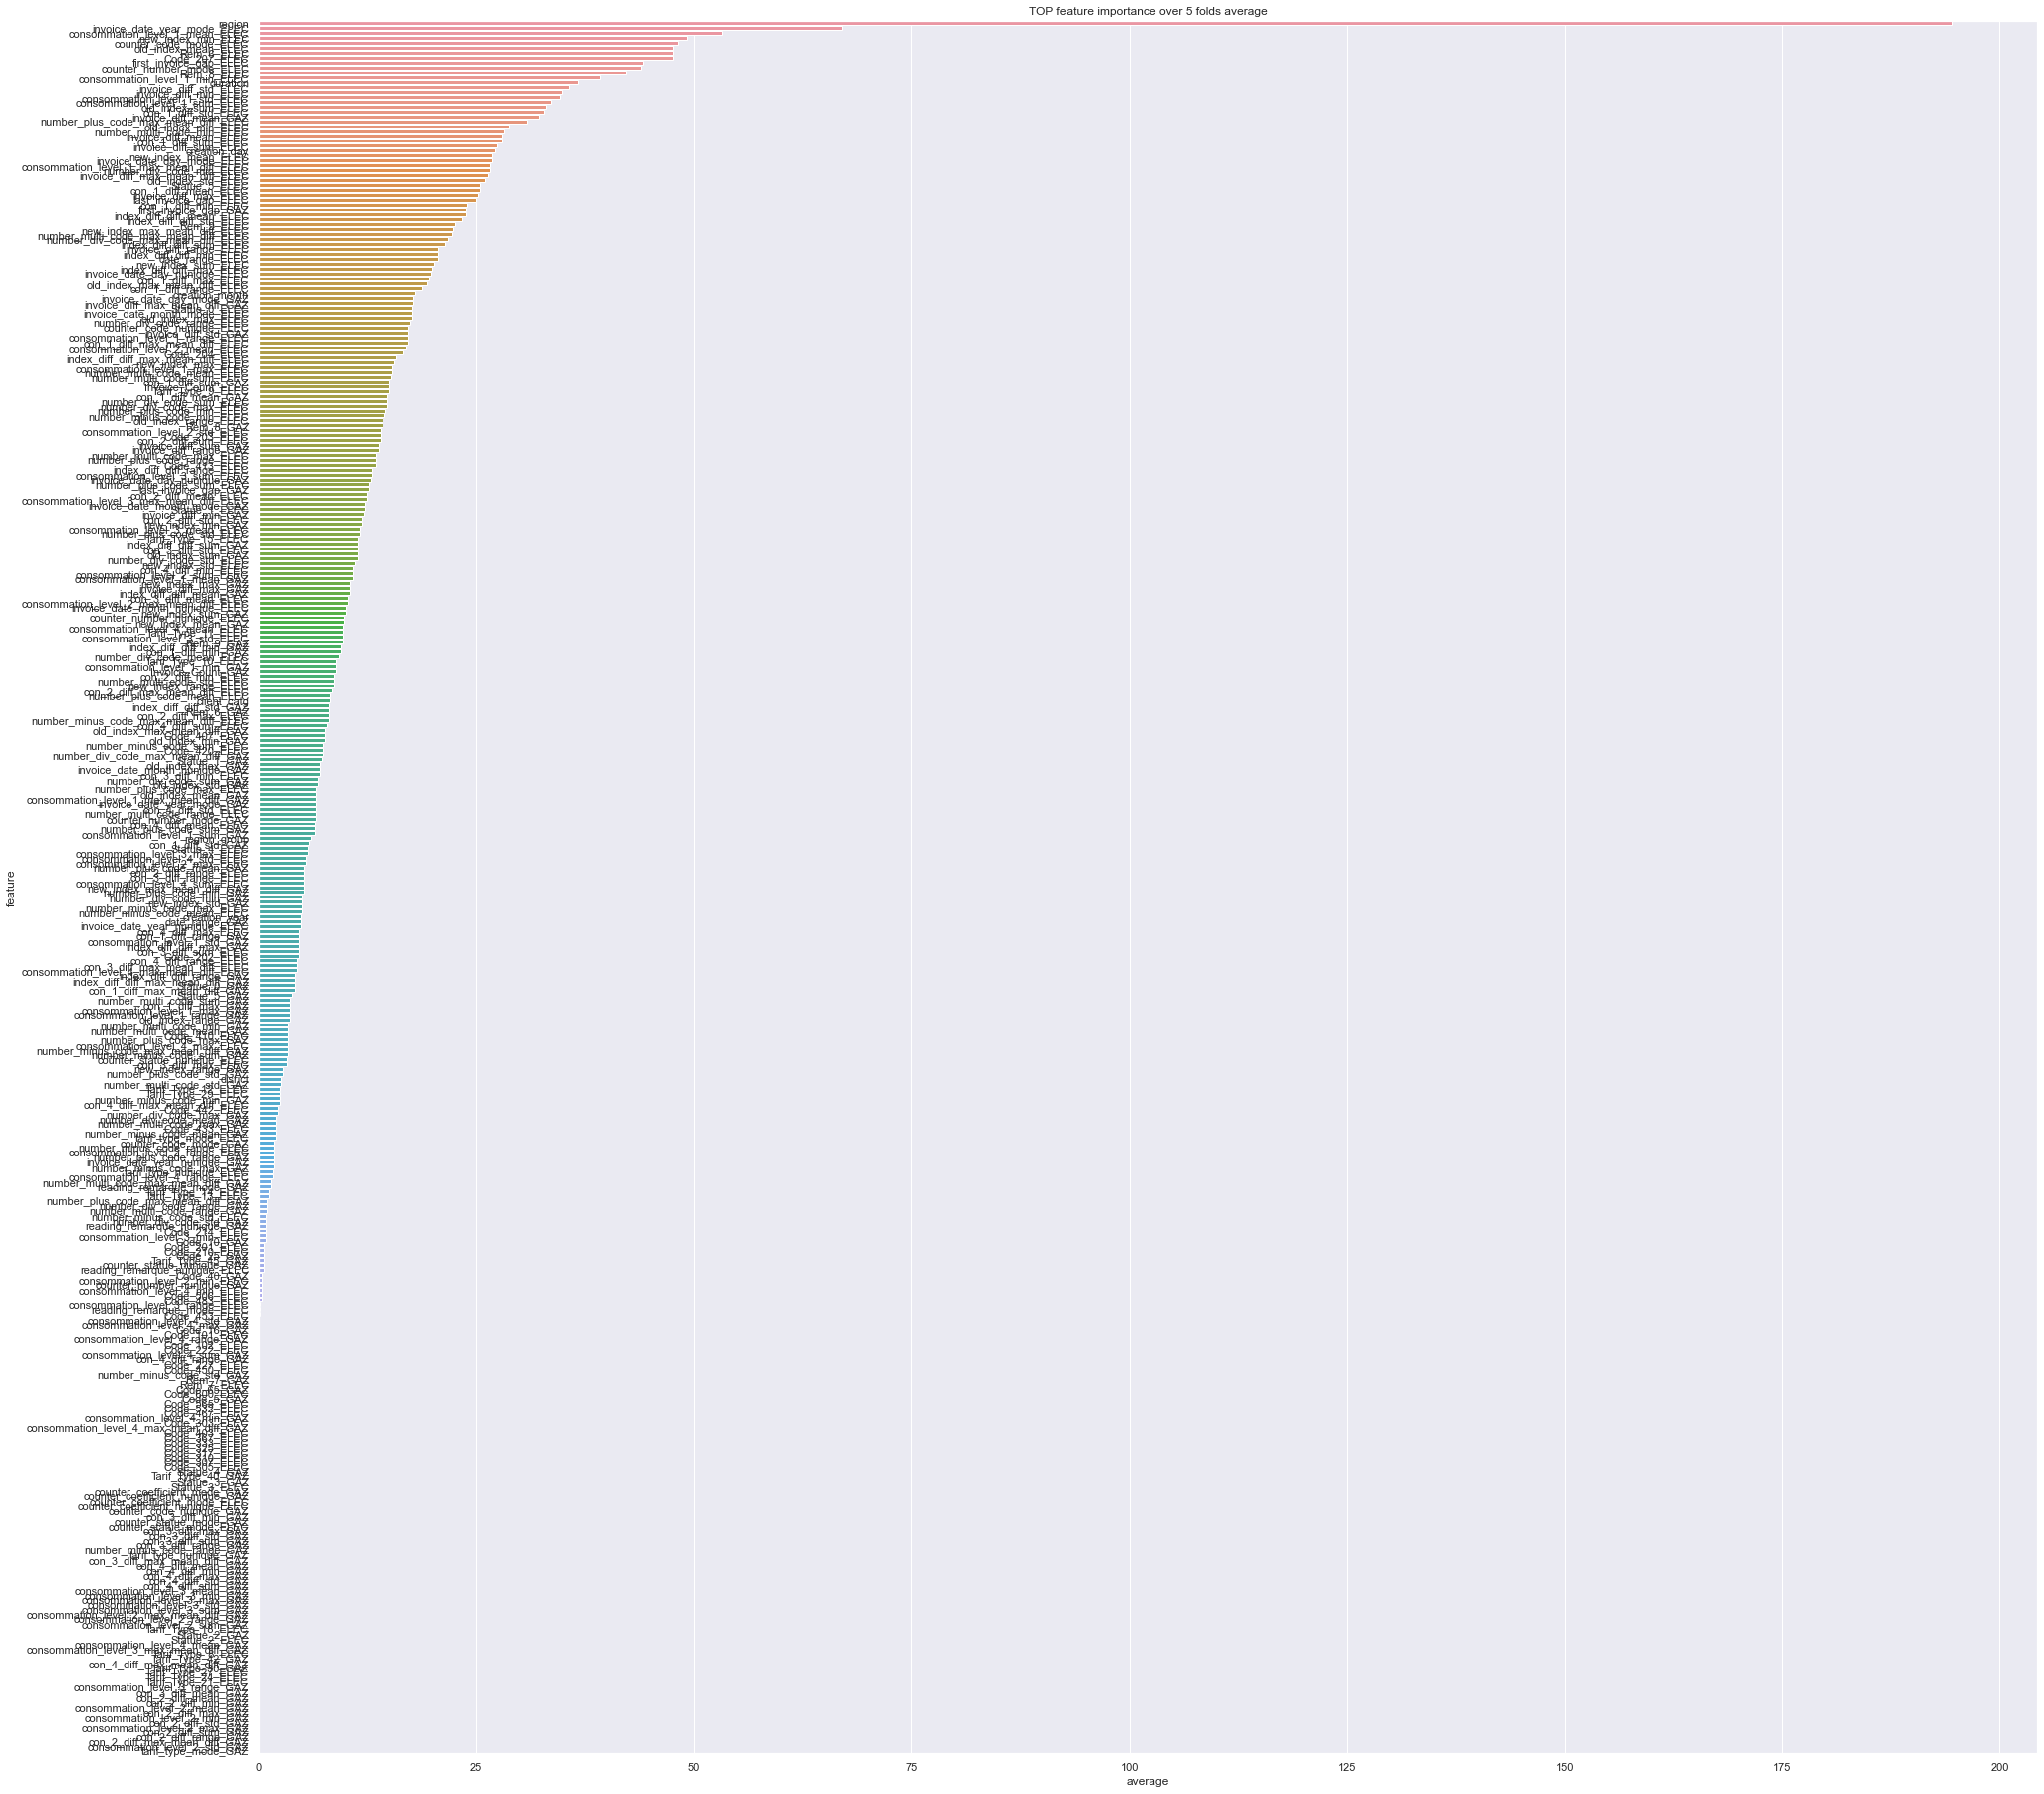

In [ ]:
plt.figure(figsize=(32, 32))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False), x='average', y='feature');
plt.title(f'TOP feature importance over {stkfold.n_splits} folds average')

# Create Submission

In [ ]:
submission = pd.DataFrame({
        "client_id": sub["client_id"],
        "target": probs['target']
    })
submission.to_csv('./submission/final_lgb_all_features.csv', index=False)